<a href="https://colab.research.google.com/github/johanhoffman/DD2365_VT22/blob/main/template-report-Stokes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **The Stokes equations**
**Johan Hoffman**

# **Abstract**

This short report show an example on how to use FEniCS to solve the Stokes equations, which is used in the course DD2365 Advanced Computation in Fluid Mechanics, at the KTH Royal Institute of Technology.

[DD2365 course website.](https://kth.instructure.com/courses/17071)

# **About the code**

In [1]:
"""This program is an example file for the course"""
"""DD2365 Advanced Computation in Fluid Mechanics, """
"""KTH Royal Institute of Technology, Stockholm, Sweden."""

# Copyright (C) 2020 Johan Hoffman (jhoffman@kth.se)

# This file is part of the course DD2365 Advanced Computation in Fluid Mechanics
# KTH Royal Institute of Technology, Stockholm, Sweden
#
# This is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# This template is maintained by Johan Hoffman
# Please report problems to jhoffman@kth.se

'KTH Royal Institute of Technology, Stockholm, Sweden.'

# **Set up environment**

In [2]:
# Load neccessary modules.
from google.colab import files

import numpy as np
import time

# Install FEniCS (this may take a long time)
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin
    
from dolfin import *; from mshr import *

import dolfin.common.plotting as fenicsplot

from matplotlib import pyplot as plt

# **Introduction**

The Stokes equations take the form

$\nabla p -\Delta u = f,\quad \nabla \cdot u=0$

together with suitable boundary conditions.

Here we present a FEniCS implementation of a mixed finite element method to solve the Stokes equations in 2D. The solution is visualized using FEniCS plotting functions, and is also exported as pvd-files which can be visualized in Paraview.

To derive the weak form of the equations, multiply the momentum equation by $v\in V$ and the continuity equation by $q\in Q$, and then integrate over the domain $\Omega$ and use Green's formula
$
(\nabla p -\Delta u,v) = -(p,\nabla \cdot v) + (\nabla u, \nabla v) 
+ <pn - \nabla u\cdot n, v>_{\Gamma}
$

We seek a finite element approximation $(u,p)\in V\times Q$ such that 

$- (p,\nabla \cdot v) + (\nabla u,\nabla v) + (\nabla \cdot u, q) 
+ <pn - \nabla u\cdot n, v>_{\partial \Omega} = (f,v)$

for all test functions $(v,q) \in V\times Q$. 

$
(v,w) = \int_{\Omega} v\cdot w ~dx, \quad 
<v,w>_{\partial \Omega} = \int_{\partial \Omega} v\cdot w~ds
$

We divide the boundary into $\partial \Omega=\Gamma_D \cup \Gamma_N$, with the different boundary conditions

$
u = g_D,\quad x\in \Gamma_D,
$

$
-\nu \nabla u\cdot n + pn = g_N, \quad x\in \Gamma_N,
$

For $x\in \Gamma_D$ the test function $v=0$. Hence, with $g_N=0$ the boundary term is zero. 

The equations can be expressed in residual form

$r(u,p;v,q) = - (p,\nabla \cdot v) + (\nabla u,\nabla v) + (\nabla \cdot u, q) - (f,v)$

We use inf-sup stable Taylor-Hood approximation spaces, 
and to implement the velocity boundary conditions we use a penalty formulation, with a penalty parameter $\gamma = C/h$, with $C>0$ a constant and $h$ the local mesh size. At outflow we use a "do nothing" stress free boundary condition. 


# **Method**

**Define domain and mesh**

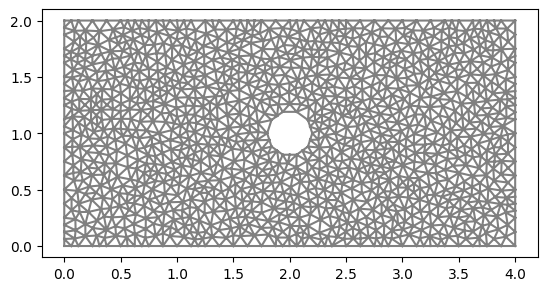

In [3]:
# Define rectangular domain 
L = 4
H = 2

# Generate mesh (examples with and without a hole in the mesh) 
resolution = 32
#mesh = RectangleMesh(Point(0.0, 0.0), Point(L, H), L*resolution, H*resolution)
mesh = generate_mesh(Rectangle(Point(0.0,0.0), Point(L,H)) - Circle(Point(0.5*L,0.5*H),0.2), resolution)
#mesh = generate_mesh(Rectangle(Point(0.0,0.0), Point(L,H)) - Circle(Point(1.5,0.25*H),0.2) - Circle(Point(0.5,0.5*H),0.2) - Circle(Point(2.0,0.75*H),0.2), resolution)

plt.figure()
plot(mesh)
plt.show()

## Mesh refinement

Here we refine the mesh centered around the circle with radius 1. 

We can see from the plot of the mesh that it is clearly much finer there than elsewhere and it is finer than the mesh was before.

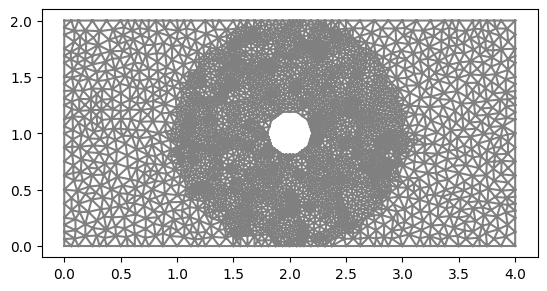

In [4]:
# Local mesh refinement (specified by a cell marker)
no_levels = 1
for i in range(0,no_levels):
  cell_marker = MeshFunction("bool", mesh, mesh.topology().dim())
  for cell in cells(mesh):
    cell_marker[cell] = False
    p = cell.midpoint()
    if p.distance(Point(0.5*L, 0.5*H)) < 1.0:
        cell_marker[cell] = True
  mesh = refine(mesh, cell_marker)

plt.figure()
plot(mesh)
plt.show()

**Define finite element approximation spaces**

We define the approximation spaces for both a quadratic velocity space and a linear velocity space, while in both cases the pressure space is linear. We do this so it is easy to compare the results of them both.

In [5]:
# Generate mixed finite element spaces (for velocity and pressure)
VE = VectorElement("CG", mesh.ufl_cell(), 2)
QE = FiniteElement("CG", mesh.ufl_cell(), 1)
WE = VE * QE

W = FunctionSpace(mesh, WE)
V = FunctionSpace(mesh, VE)
Q = FunctionSpace(mesh, QE)

# Define trial and test functions
w = Function(W)
(u, p) = (as_vector((w[0],w[1])), w[2])
(v, q) = TestFunctions(W) 

VE1 = VectorElement("CG", mesh.ufl_cell(), 1) 
WE1 = VE1 * QE

W1 = FunctionSpace(mesh, WE1)
V1 = FunctionSpace(mesh, VE1)

w1 = Function(W1)
(u1, p1) = (as_vector((w1[0],w1[1])), w1[2])
(v1, q1) = TestFunctions(W1) 

**Define boundary conditions**

We also use the correct boundary conditions for both cases of the velocity space, linear (V1) and quadratic (V).

If we change sign of the inflow, uin, we are changing the direction of the flow so it will go from right to left instead of left to right,
we do that for the linear case. So we can see the difference in the results.



In [6]:
# Examples of inflow and outflow conditions
XMIN = 0.0; XMAX = L
YMIN = 0.0; YMAX = H

# If we change sign of the inflow, uin, we are changing the direction of the flow
# so it will go from right to left instead of left to right,
# we do that for the linear case

uin = Expression(("4*(x[1]*(YMAX-x[1]))/(YMAX*YMAX)", "0."), YMAX=YMAX, element = V.ufl_element()) 
uin1 = Expression(("-4*(x[1]*(YMAX-x[1]))/(YMAX*YMAX)", "0."), YMAX=YMAX, element = V1.ufl_element()) 
#pout = 0.0

# Inflow boundary (ib), outflow boundary (ob) and wall boundary (wb)
ib = Expression("near(x[0],XMIN) ? 1. : 0.", XMIN=XMIN, element = Q.ufl_element())
ob = Expression("near(x[0],XMAX) ? 1. : 0.", XMAX=XMAX, element = Q.ufl_element()) 
wb = Expression("x[0] > XMIN + DOLFIN_EPS && x[0] < XMAX - DOLFIN_EPS ? 1. : 0.", XMIN=XMIN, XMAX=XMAX, element = Q.ufl_element())

# **Results**

**Define and solve variational problem**

If we add the term $s(P,q)=:spq$, which is the Brezzi-Pitkäranta stabilization term. More specifically,
$s(P,q) = c \int_Ω h^2 \nabla P \cdot \nabla q$.
In our code if we uncomment the, we get rid of the spurious oscillations which we talk about later.



In [7]:
h = CellDiameter(mesh)
C = 1.0e3
gamma = C/h

f = Expression(("0.0","0.0"), element = V.ufl_element())

# Define variational problem on residual form: r(u,p;v,q) = 0
residual = ( - p*div(v)*dx + inner(grad(u), grad(v))*dx + div(u)*q*dx + 
            gamma*(ib*inner(u - uin, v) + wb*inner(u, v))*ds - inner(f, v)*dx )
spq = 0
residual1 = ( - p1*div(v1)*dx + inner(grad(u1), grad(v1))*dx + div(u1)*q1*dx + spq + 
            gamma*(ib*inner(u1 - uin1, v1) + wb*inner(u1, v1))*ds - inner(f, v1)*dx )

spq = h**2*(inner(grad(p1),grad(q1)))*dx
residual1s = ( - p1*div(v1)*dx + inner(grad(u1), grad(v1))*dx + div(u1)*q1*dx + spq + 
            gamma*(ib*inner(u1 - uin1, v1) + wb*inner(u1, v1))*ds - inner(f, v1)*dx )

# Solve algebraic system 
solve(residual == 0, w) 
solve(residual1 == 0, w1) 

**Visualize solution and export files**

rm: cannot remove 'results-NS/*': No such file or directory


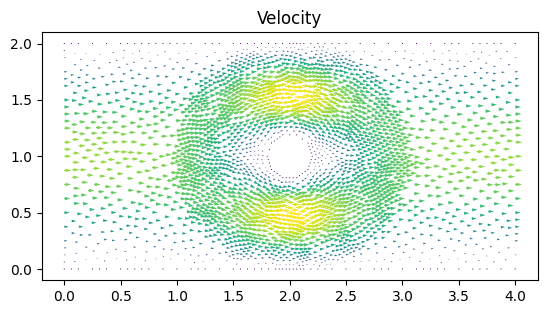

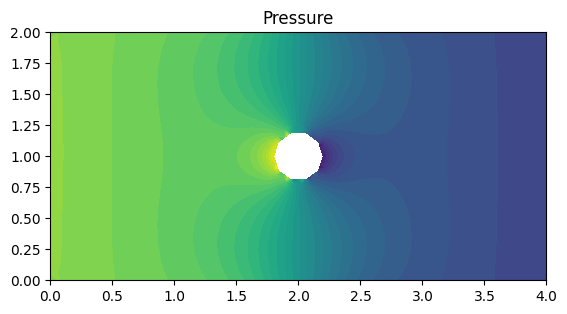

In [8]:
!rm results-NS/*

# Open files to export solution to Paraview
file_u = File("results-Stokes/u.pvd")
file_p = File("results-Etokes/p.pvd")

up = project(u, V)
pp = project(p, Q)

# Save solution to file
file_u << up
file_p << pp

# Plot solution
plt.figure()
plot(up, title="Velocity")

plt.figure()
plot(pp, title="Pressure")
        
plt.show()

rm: cannot remove 'results-NS/*': No such file or directory


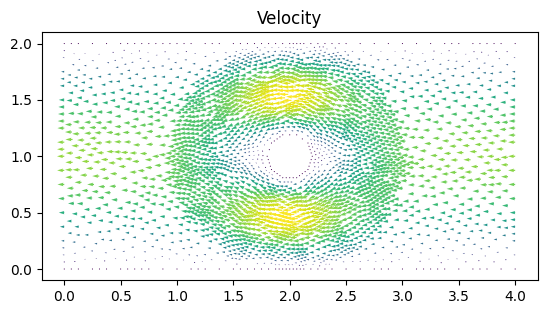

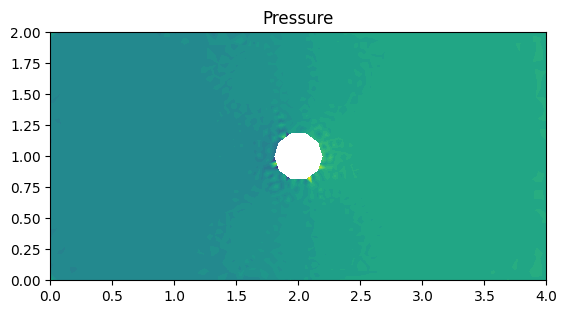

In [9]:
!rm results-NS/*

# Open files to export solution to Paraview
file_u = File("results-Stokes/u1.pvd")
file_p = File("results-Etokes/p1.pvd")

u1p = project(u1, V1)
p1p = project(p1, Q)

# Save solution to file
file_u << u1p
file_p << p1p

# Plot solution
plt.figure()
plot(u1p, title="Velocity")

plt.figure()
plot(p1p, title="Pressure")
        
plt.show()

In [10]:
spq = h**2*(inner(grad(p1),grad(q1)))*dx
residual1s = ( - p1*div(v1)*dx + inner(grad(u1), grad(v1))*dx + div(u1)*q1*dx + spq + 
            gamma*(ib*inner(u1 - uin1, v1) + wb*inner(u1, v1))*ds - inner(f, v1)*dx )

solve(residual1s == 0, w1)

rm: cannot remove 'results-NS/*': No such file or directory


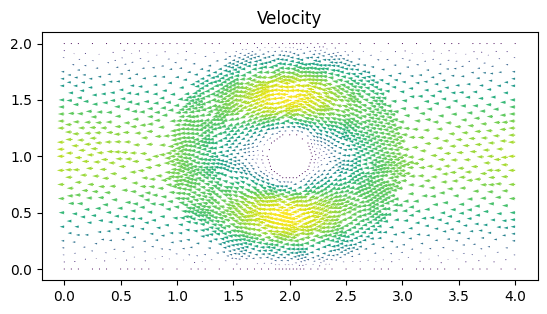

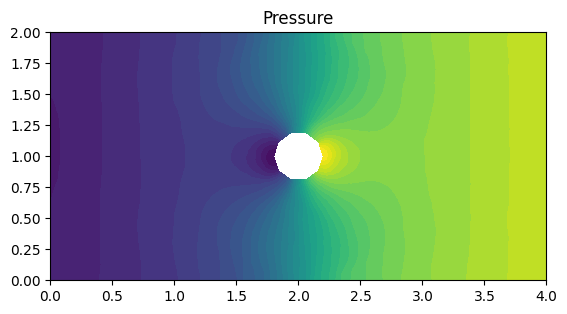

In [11]:
!rm results-NS/*

# Open files to export solution to Paraview
file_u = File("results-Stokes/u1.pvd")
file_p = File("results-Etokes/p1.pvd")

u1ps = project(u1, V1)
p1ps = project(p1, Q)

# Save solution to file
file_u << u1ps
file_p << p1ps

# Plot solution
plt.figure()
plot(u1ps, title="Velocity")

plt.figure()
plot(p1ps, title="Pressure")
        
plt.show()

## Results

We see that for the case where the velocity space is linear, we get spurious oscillations around the center of the cylinder in the resulting pressure approximation. And even though the mesh is refined around the cylinder it does appear help. 

# **Discussion**

A Taylor-Hood mixed finite element method was implemented in FEniCS to solve the Stokes equations in 2D. The method was tested for the model problem of flow past a number of circular obstacles, and the solution behaved as expected.  